In [143]:
terrain_palette = {
    "ocean": [
        (0, 25, 51),
        (2, 49, 96),
        (0, 68, 136),
        (3, 83, 162),
        (0, 153, 204),
        (102, 221, 238),
    ],
    "lake": [
        (14, 64, 104),
        (24, 88, 141),
        (43, 92, 125),
        (62, 130, 166),
        (112, 175, 194),
        (160, 212, 225),
    ],
    "river": [
        (0, 40, 80),    # deep river (dark navy)
        (0, 60, 120),   # mid-deep blue
        (0, 90, 160),   # medium blue
        (30, 120, 190), # lighter, reflective
        (70, 160, 220), # sunlit/shallow
        (150, 200, 240) # highlight / surface shine
    ],
    "pond": [
        (0, 50, 60),    # deep pond / shadow
        (20, 80, 90),   # mid-deep
        (40, 110, 120), # standard pond
        (70, 140, 150), # shallow / sunlit
        (110, 180, 190),# reflective surface
        (160, 220, 230) # highlight / edges
    ],

    "beach": [
        (253, 245, 230),
        (252, 231, 199),
        (248, 217, 163),
        (242, 201, 123),
        (230, 179, 92),
        (217, 161, 67),
    ],
    "grassland": [
        (44, 95, 45),
        (62, 125, 63),
        (94, 168, 107),
        (127, 207, 141),
        (162, 229, 176),
        (196, 242, 204),
    ],
    "dirt": [
        (62, 39, 35),
        (93, 64, 55),
        (121, 85, 72),
        (160, 82, 45),
        (205, 133, 63),
        (222, 184, 135),
    ],
    "mountain": [
        (60, 50, 50),   # base rock / shadow
        (100, 85, 80),  # mid-dark rock
        (130, 110, 100),# standard rock
        (160, 140, 125),# sunlit rock
        (190, 170, 150),# lighter highlight
        (220, 200, 180) # peak / snow-dusted highlight
    ],

    "ice_cap": [
        (200, 220, 230),# icy shadow
        (210, 230, 240),# light ice
        (220, 240, 250),# bright ice
        (230, 245, 255),# reflective ice
        (240, 250, 255),# near-white
        (250, 255, 255) # pure highlight
    ],
    "forest": [
        (20, 40, 20),   # deep shadow / dense undergrowth
        (35, 60, 35),   # dark green / thick trees
        (50, 85, 50),   # standard foliage
        (70, 110, 70),  # mid-light leaves
        (100, 145, 100),# sunlit leaves
        (150, 200, 150) # bright highlights / young foliage
    ],
    "beach": [
        (253, 245, 230),  # very pale dry sand (top layer)
        (252, 231, 199),  # light sand
        (248, 217, 163),  # mid sand
        (242, 201, 123),  # golden sand
        (230, 179, 92),   # wet sand near water
        (217, 161, 67)    # darker wet sand / edges
    ]



}



In [144]:
from PIL import Image, ImageDraw
import os
from IPython.display import display
import noise  # pip install noise
import numpy as np
import random

# Parameters for tile generation
TILE_SIZE = 256 # output image size in pixels
CUBE_HEIGHT = 128  # vertical height of the cube in pixels
OUTPUT_DIR = "./"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [145]:
NOISE_SCALE = 2
NOISE_GRANU = 6

def generate_face_perlin(width, height, colors=[(0,255,0)]):
    img = Image.new("RGB", (width, height))
    # random offsets for x and y to add variation
    x_offset = random.uniform(0, 100)
    y_offset = random.uniform(0, 100)
    
    for y in range(height):
        for x in range(width):
            n = noise.pnoise2((x + x_offset) / NOISE_SCALE, 
                              (y + y_offset) / NOISE_SCALE, 
                              octaves=NOISE_GRANU)
            idx = int((n + 0.5) * (len(colors)-1))
            idx = max(0, min(len(colors)-1, idx))
            img.putpixel((x, y), colors[idx])
    return img


In [146]:
from PIL import Image, ImageDraw
import random, noise
import math

def generate_grass(rgb_shift:tuple = (0,0,0)):
    SIZE = 256
    dr,dg,db = rgb_shift
    img = Image.new("RGB", (SIZE, SIZE), (34+dr, 80+dg, 0+db))
    draw = ImageDraw.Draw(img)

    # --- Step 1: base noise shading ---
    for y in range(SIZE):
        for x in range(SIZE):
            n = noise.pnoise2(x/50, y/50, octaves=3)
            shade = int(40 * n)
            r, g, b = img.getpixel((x, y))
            draw.point((x, y), (
                max(0, r+shade + dr),
                min(255, g+shade + dg),
                max(0, b+shade + db)
            ))

    # --- Step 2: draw blades ---
    for _ in range(10000):  # more blades for detail
        x = random.randint(0, SIZE-1)
        y = random.randint(0, SIZE-1)
        length = random.randint(5, 15)   # varied blade sizes
        curve = random.uniform(-.6, .6)

        # base blade color
        base_green = random.randint(60, 180)

        # draw blade as small segments (to curve it)
        px, py = x, y
        for i in range(length):
            # color gradient along blade
            color = (20+dr, min(200, base_green + i*2 + dg), 20 + i + db)

            # slight curve in x direction
            nx = px + curve
            ny = py - 1

            width = max(1, 2)
            draw.line((px, py, nx, ny), fill=color, width=width)
            px, py = nx, ny


    return img

In [147]:
def apply_transition_gradient(img, dx, dy, B=60, start = 0.3, end = 0.9):
    SIZE = img.size[0]
    draw = ImageDraw.Draw(img)

    # normalize direction
    length = math.sqrt(dx*dx + dy*dy)
    if length == 0: 
        return img
    dx, dy = dx/length, dy/length

    # get min/max projections for normalization
    projs = []
    for y in (0, SIZE):
        for x in (0, SIZE):
            projs.append(x*dx + y*dy)
    min_proj, max_proj = min(projs), max(projs)

    for y in range(SIZE):
        for x in range(SIZE):
            proj = (x*dx + y*dy - min_proj) / (max_proj - min_proj)  # 0..1 range

            # region logic
            if proj < start:
                brightness = 0
            elif proj > end:
                brightness = B
            else:
                # normalize inside gradient band
                t = (proj - start) / (end - start)
                brightness = int(B * t)

            # apply brightness shift
            r, g, b = img.getpixel((x, y))
            r = min(255, max(0, r + brightness))
            g = min(255, max(0, g + brightness))
            b = min(255, max(0, b + brightness))
            draw.point((x, y), (r, g, b))

    return img


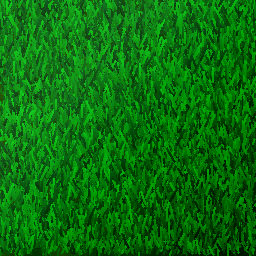

In [148]:
B = -50
grass_texture = generate_grass()
grass_texture = apply_transition_gradient(grass_texture, 1, 1, B)
display(grass_texture)

In [149]:

from PIL import Image, ImageDraw
class IsometricTile:
    def __init__(self,
                 tile_size,
                 cube_size,
                 top_img:Image.Image | None = None,
                 lft_img:Image.Image | None = None,
                 rgt_img:Image.Image | None = None,
                 top_colors: list[tuple[int,int,int]] | None = None,
                 lft_colors: list[tuple[int,int,int]] | None = None,
                 rgt_colors: list[tuple[int,int,int]] | None = None,
                 ):
        self.tile_size = tile_size
        self.cube_size = cube_size
        self.top_img = top_img
        self.lft_img = lft_img
        self.rgt_img = rgt_img
        self.top_colors = [(val,val,val) for val in range(100,255)] if top_colors is None else top_colors
        self.lft_colors = [(val,val,val) for val in range(  0,150)] if lft_colors is None else lft_colors
        self.rgt_colors = [(val,val,val) for val in range(150,255)] if rgt_colors is None else rgt_colors
        self.image = None
        # self.draw = ImageDraw.Draw(self.tile)

    def get_image(self):
        self.draw()
        return self.image

    def draw(self, draw_edge:bool = False):

        self.image = Image.new("RGBA", (self.tile_size, self.tile_size))
        cx = self.tile_size // 2
        cy = self.tile_size // 2
        half_width = self.tile_size // 2
        half_height = self.tile_size // 4

        # Define faces
        top = [(cx - half_width, cy - half_height), (cx, cy - half_height*2), (cx + half_width, cy - half_height), (cx, cy)]
        left = [top[0], top[3], (top[3][0], top[3][1] + self.cube_size), (top[0][0], top[0][1] + self.cube_size)]
        right = [top[2], top[3], (top[3][0], top[3][1] + self.cube_size), (top[2][0], top[2][1] + self.cube_size)]

        # Masks
        top_mask = Image.new("L", (self.tile_size, self.tile_size), 0)
        ImageDraw.Draw(top_mask).polygon(top, fill=255)
        left_mask = Image.new("L", (self.tile_size, self.tile_size), 0)
        ImageDraw.Draw(left_mask).polygon(left, fill=255)
        right_mask = Image.new("L", (self.tile_size, self.tile_size), 0)
        ImageDraw.Draw(right_mask).polygon(right, fill=255)

        # Contrast left-right faces is using the same palette
        lft_colors = [(max(  0,r-30),max(  0,g-30),max(  0,b-30)) for r,g,b in self.lft_colors]
        rgt_colors = [(min(255,r+30),min(255,g+30),min(255,b+30)) for r,g,b in self.rgt_colors]

        # Generate Perlin faces
        top_face = self.top_img if self.top_img else generate_face_perlin(self.tile_size, self.tile_size, colors=self.top_colors)
        lft_face = self.lft_img if self.lft_img else generate_face_perlin(self.tile_size, self.tile_size, colors=lft_colors)
        rgt_face = self.rgt_img if self.rgt_img else generate_face_perlin(self.tile_size, self.tile_size, colors=rgt_colors)

        # Paste faces
        self.image.paste(top_face, (0,0), top_mask)
        self.image.paste(lft_face, (0,0), left_mask)
        self.image.paste(rgt_face, (0,0), right_mask)

        # Draw edges for lateral faces
        if draw_edge:
            draw = ImageDraw.Draw(self.image)
            draw.line(left + [left[0]], fill=(0,0,0), width=1)
            draw.line(right + [right[0]], fill=(0,0,0), width=1)

        display(self.image)

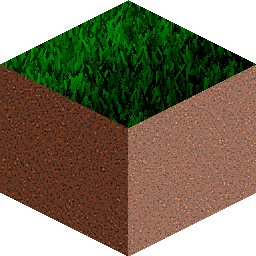

In [150]:

n_of_samples = 1
tile = IsometricTile(tile_size=256,cube_size=128,lft_colors=terrain_palette["dirt"],rgt_colors=terrain_palette["dirt"])
for sample in range(n_of_samples):
    # texture_path = f"terrains/grassland/tile_{sample:02d}.png"
    # grass_texture = generate_grass()
    # tile.top_img = grass_texture
    # image = tile.get_image()
    # save_path = os.path.join(OUTPUT_DIR, f"tile_{sample:03d}.png")

    # os.makedirs(os.path.dirname(texture_path), exist_ok=True)
    # image.save(texture_path, "PNG")

    texture_path = f"terrains/forest/tile_{sample:02d}.png"
    grass_texture = generate_grass((-50,-50,-50))

    directions = [(0.5,1), (-0.5,1), (1,1), (-1,1)]
    grass_texture = apply_transition_gradient(grass_texture, 0.5, 1, B, 0.25, 0.40)
    tile.top_img = grass_texture
    image = tile.get_image()
    save_path = os.path.join(OUTPUT_DIR, f"tile_{sample:03d}.png")

    os.makedirs(os.path.dirname(texture_path), exist_ok=True)
    image.save(texture_path, "PNG")


In [151]:

# Function to stretch the image along a direction (dx, dy) and crop back to original size
# This creates a 'brush-like' stretching effect while keeping the same dimensions
def stretch_image_in_place(img, dx, dy, factor):
    w, h = img.size
    arr = np.array(img, dtype=np.float32)
    output = np.zeros_like(arr)
    count = np.zeros((h, w), dtype=np.int32)

    # Normalize direction vector
    length = (dx**2 + dy**2)**0.5
    if length == 0:
        return img
    ux, uy = dx/length, dy/length

    max_steps = int(factor * max(w, h))

    for y in range(h):
        for x in range(w):
            color = arr[y, x]
            for step in range(max_steps):
                new_x = int(x + ux * step)
                new_y = int(y + uy * step)
                if 0 <= new_x < w and 0 <= new_y < h:
                    output[new_y, new_x] += color
                    count[new_y, new_x] += 1
                else:
                    break

    # Average overlapping pixels
    mask = count > 0
    output[mask] = output[mask] / count[mask][:, None]

    return Image.fromarray(output.astype(np.uint8))


In [152]:
# Function to generate a cube tile with customizable colors for each face
def generate_cube_tile_faces(cube_height=CUBE_HEIGHT,
                             top_image: Image.Image | None = None,
                             top_colors  :list[tuple[int,int,int]]=terrain_palette["grassland"],
                             left_colors :list[tuple[int,int,int]]=terrain_palette["dirt"],
                             right_colors:list[tuple[int,int,int]]=terrain_palette["dirt"],
                             filename="cube_tile_custom.png",
                             stretch_dir:list[tuple[float,float,float]] = [(0,0,0)]):
    image = Image.new("RGBA", (TILE_SIZE, TILE_SIZE), (0, 0, 0, 0))

    cx = TILE_SIZE // 2
    cy = TILE_SIZE // 2
    half_width = TILE_SIZE // 2
    half_height = TILE_SIZE // 4

    # Define faces
    top = [(cx - half_width, cy - half_height), (cx, cy - half_height*2), (cx + half_width, cy - half_height), (cx, cy)]
    left = [top[0], top[3], (top[3][0], top[3][1] + cube_height), (top[0][0], top[0][1] + cube_height)]
    right = [top[2], top[3], (top[3][0], top[3][1] + cube_height), (top[2][0], top[2][1] + cube_height)]

    # Masks
    top_mask = Image.new("L", (TILE_SIZE, TILE_SIZE), 0)
    ImageDraw.Draw(top_mask).polygon(top, fill=255)
    left_mask = Image.new("L", (TILE_SIZE, TILE_SIZE), 0)
    ImageDraw.Draw(left_mask).polygon(left, fill=255)
    right_mask = Image.new("L", (TILE_SIZE, TILE_SIZE), 0)
    ImageDraw.Draw(right_mask).polygon(right, fill=255)

    #  Darken left face
    left_colors = [(max(0,r-50),max(0,g-50),max(0,b-50)) for r,g,b in left_colors]
    right_colors = [(min(255,r+50),min(255,g+50),min(255,b+50)) for r,g,b in right_colors]
        
    # Generate Perlin faces
    top_img = generate_face_perlin(TILE_SIZE, TILE_SIZE, colors=top_colors)
    left_img = generate_face_perlin(TILE_SIZE, TILE_SIZE, colors=left_colors)
    right_img = generate_face_perlin(TILE_SIZE, TILE_SIZE, colors=right_colors)

    top_img   = stretch_image_in_place(top_img, stretch_dir[0][0], stretch_dir[0][1], stretch_dir[0][2])

    # Paste faces
    if top_image:
        top_img = top_image

    if len(stretch_dir) > 1:
        left_img  = stretch_image_in_place(left_img,  stretch_dir[1][0], stretch_dir[1][1], stretch_dir[1][2])
    if len(stretch_dir) > 2:
        right_img = stretch_image_in_place(right_img, stretch_dir[2][0], stretch_dir[2][1], stretch_dir[2][2])

    # Paste faces
    image.paste(top_img, (0,0), top_mask)
    image.paste(left_img, (0,0), left_mask)
    image.paste(right_img, (0,0), right_mask)

    # Draw edges for lateral faces
    draw = ImageDraw.Draw(image)
    # draw.line(left + [left[0]], fill=(0,0,0), width=1)
    # draw.line(right + [right[0]], fill=(0,0,0), width=1)

    save_path = os.path.join(OUTPUT_DIR, filename)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    image.save(save_path, "PNG")
    # display(image)


In [153]:

n_of_samples = 10
for i in range(n_of_samples):
    grass = generate_grass()
    forest = generate_grass((-50,-50,-50))

    NOISE_SCALE = 10
    generate_cube_tile_faces(CUBE_HEIGHT, grass,terrain_palette["grassland"], terrain_palette["dirt"], terrain_palette["dirt"], f"terrains/grassland/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT, forest, terrain_palette["forest"], terrain_palette["dirt"], terrain_palette["dirt"], f"terrains/forest/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT, None, terrain_palette["mountain"], terrain_palette["mountain"], terrain_palette["mountain"], f"terrains/mountain/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT, None, terrain_palette["ice_cap"], terrain_palette["ice_cap"], terrain_palette["ice_cap"], f"terrains/ice_cap/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT, None, terrain_palette["beach"], terrain_palette["beach"], terrain_palette["beach"], f"terrains/beach/tile_{i:02d}.png")


    NOISE_SCALE = 20
    generate_cube_tile_faces(CUBE_HEIGHT//2, None, terrain_palette["river"], terrain_palette["river"], terrain_palette["river"], f"terrains/river/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT//2, None, terrain_palette["lake"],  terrain_palette["lake"],  terrain_palette["lake"],  f"terrains/lake/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT//2, None, terrain_palette["ocean"], terrain_palette["ocean"], terrain_palette["ocean"], f"terrains/ocean/tile_{i:02d}.png")
    generate_cube_tile_faces(CUBE_HEIGHT//2, None, terrain_palette["pond"], terrain_palette["pond"], terrain_palette["pond"], f"terrains/pond/tile_{i:02d}.png")
